# Hybrid Recommendation System dengan Collaborative Filtering dan Content Based



**DATASET**

---
All data is sourced from the MovieLens Dataset, which contains 100,000 movie ratings given by 600 users on 9,000 movies in 2018.

# **Hybrid Recommender System**

In [ ]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import time
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import minmax_scale

# Setting plot style
plt.style.use('ggplot')

## 1. Data Exploration and Analysis

In [ ]:
# movies.csv
!gdown --id 1xfrG1HkVMBmQM9ElBqhZJIgmUIUPkIqL
df_movie = pd.read_csv("movies.csv")
# ratings.csv
!gdown --id 1focO3uaSD3GKywg-_teoKWdEcGk4DbHm
df_rating = pd.read_csv("ratings.csv")

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xfrG1HkVMBmQM9ElBqhZJIgmUIUPkIqL
To: /content/movies.csv
100% 494k/494k [00:00<00:00, 132MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1focO3uaSD3GKywg-_teoKWdEcGk4DbHm
To: /content/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 66.8MB/s]


In [ ]:
# Load Dataset
df_rating = pd.read_csv('/content/ratings.csv')
df_movie = pd.read_csv('/content/movies.csv')

### 1.1 Rating and Movie Dataset Exploration

In [ ]:
# Print dataset rating.
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Look at the description of the dataset in the user Id, movieId, and rating columns.
df_rating[["userId","movieId", "rating"]].describe(include="all")

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


The average rating across all users and movies is 3.50. This figure is high, the hypothesis is that most people have watched films recommended to them, either by other people or by the recommendation system.

In [ ]:
# Print dataset movie
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Creates a new genre feature from genre data

dummies = df_movie['genres'].str.get_dummies(sep='|')
movie_genre = pd.concat([df_movie, dummies], axis=1)

In [ ]:
# See info for each feature

movie_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             9742 non-null   int64 
 1   title               9742 non-null   object
 2   genres              9742 non-null   object
 3   (no genres listed)  9742 non-null   int64 
 4   Action              9742 non-null   int64 
 5   Adventure           9742 non-null   int64 
 6   Animation           9742 non-null   int64 
 7   Children            9742 non-null   int64 
 8   Comedy              9742 non-null   int64 
 9   Crime               9742 non-null   int64 
 10  Documentary         9742 non-null   int64 
 11  Drama               9742 non-null   int64 
 12  Fantasy             9742 non-null   int64 
 13  Film-Noir           9742 non-null   int64 
 14  Horror              9742 non-null   int64 
 15  IMAX                9742 non-null   int64 
 16  Musical             9742

In [ ]:
# Drop the genre column and no genre list.

df_movie = movie_genre.drop(['genres', '(no genres listed)'], axis=1)
df_movie.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# View a description of the new movie dataset
df_movie.describe()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,42200.353623,0.187641,0.129645,0.062718,0.068158,0.385547,0.123075,0.045165,0.447649,0.079963,0.008930,0.100390,0.016218,0.034285,0.058817,0.163827,0.100595,0.194416,0.039212,0.017142
std,52160.494854,0.390445,0.335930,0.242468,0.252031,0.486749,0.328541,0.207677,0.497277,0.271250,0.094083,0.300535,0.126321,0.181968,0.235295,0.370137,0.300808,0.395771,0.194108,0.129808
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3248.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76232.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,193609.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Generate a new dataframe with the number of score ratings as columns and genres as rows.

genres = list(df_movie)[2:]
merged = pd.merge(df_rating, df_movie, on='movieId')

cleaned = merged[['movieId', 'userId', 'rating', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                  'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical',
                  'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'title']]

movie_ratings = cleaned.sort_values('movieId')
rating_scale = [1, 2, 3, 4, 5]

genres_rating_count = []
for genre in genres:
    for rating in rating_scale:
        genre_list = movie_ratings.loc[movie_ratings[genre] == 1]
        genre_rated_count = len(genre_list.loc[genre_list['rating'] == rating])
        genres_rating_count.append([genre, rating, genre_rated_count])


# Function for extracting specific ratings from all genres
def get_rating_count(score):
    rating_count = []
    for count in genres_rating_count:
        if count[1] == score:
            rating_count.append(count[2])

    return rating_count


# Function to extract total ratings for all genres
def get_total_rating_count():
    all_ratings = []
    totals = []
    for count in genres_rating_count:
        all_ratings.append(count[2])

    lower = 0
    for i in range(lower, len(all_ratings), 5):
        lower = i
        totals.append(sum(all_ratings[lower:lower+5]))

    return totals

# Dataframe results
genre_df = pd.DataFrame({'Genre': [genre for genre in genres], 'Rated 1': get_rating_count(1), 'Rated 2': get_rating_count(2),
              'Rated 3': get_rating_count(3), 'Rated 4': get_rating_count(4), 'Rated 5': get_rating_count(5),
              'Total nr of ratings': get_total_rating_count()})
genre_df["Average rating"] = (genre_df["Rated 1"] + (genre_df["Rated 2"] * 2) + (genre_df["Rated 3"] * 3) +
                             (genre_df["Rated 4"] * 4) + (genre_df["Rated 5"] * 5)) / genre_df['Total nr of ratings']
genre_df

,Genre,Rated 1,Rated 2,Rated 3,Rated 4,Rated 5,Total nr of ratings,Average rating
0,Action,904,2548,6331,7678,3750,21211,3.510207
1,Adventure,627,1769,4838,6392,3150,16776,3.576359
2,Animation,116,346,1279,1988,985,4714,3.717013
3,Children,301,721,2054,2358,1061,6495,3.486066
4,Comedy,1317,3405,8306,9659,4429,27116,3.460171
5,Crime,321,982,3116,4621,2687,11727,3.713823
6,Documentary,16,33,163,415,153,780,3.841026
7,Drama,795,2339,7541,12360,6350,29385,3.719108
8,Fantasy,286,893,2364,2988,1518,8049,3.566406
9,Film-Noir,6,33,106,292,180,617,3.983793


### 1.2 Data Visualization

#### Figure 1: Visualization of the number of ratings and rating scores for each genre

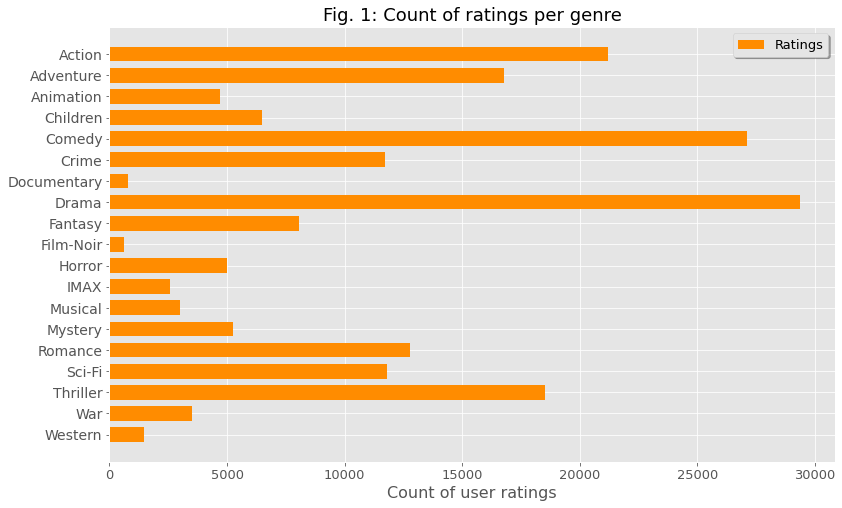

In [ ]:
# Gambar 1: Visualisasi jumlah rating dan skor rating untuk setiap genre
total_ratings = genre_df.iloc[:, 6].values.tolist()
fig2, ax2 = plt.subplots()
fig2_labels = [genre for genre in genres]
x = np.arange(len(fig2_labels))  # lokasi label
width = 0.7  # lebar dari bar
ax2.barh(x, total_ratings, width, label='Ratings', color='darkorange')

# Setting bar chart label
ax2.set_xlabel('Count of user ratings', size=16)
ax2.set_yticks(x)
ax2.set_yticklabels(fig2_labels, fontdict={'fontsize': 14})
ax2.set_title('Fig. 1: Count of ratings per genre', size=18)
ax2.invert_yaxis()  # Inverting sumbu y sehingga genre muncul menurut abjad
ax2.legend(shadow=0.4, prop={"size": 13})
plt.xticks(fontsize=13)

# Mengatur dan Menampilkan graph
fig2.set_figheight(8)
fig2.set_figwidth(13)
plt.show()

As we can see from Figure 1, there are more drama, comedy and action films in the dataset than in anything else. Most likely films with these three genres are recommended more than the others.

#### Figure 2: Visualization of the ratings for each genre as a proportion of the total number of films in that genre.

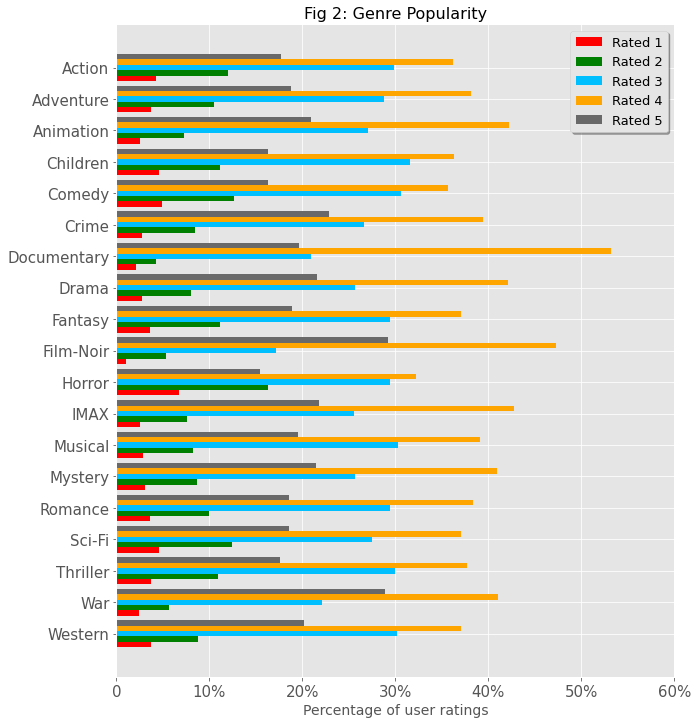

In [ ]:
# function to extract the specific rating of all genres
def get_rating_percentages(score):
    rated_count = genre_df.iloc[:, score].values.tolist()
    rating_percentages = []
    i = 0

    for total in total_ratings:
        percentage = (100 / total) * rated_count[i]
        i += 1
        rating_percentages.append(round(percentage, 1))

    return rating_percentages

# Retrieve ratings data
genre_rating_percentage_data = {'Genre': [genre for genre in genres], 'Rated 1': get_rating_percentages(1),
                                'Rated 2': get_rating_percentages(2), 'Rated 3': get_rating_percentages(3),
                                'Rated 4': get_rating_percentages(4), 'Rated 5': get_rating_percentages(5),
                                'Total nr of ratings': get_total_rating_count()}
genre_rating_percent_df = pd.DataFrame(genre_rating_percentage_data)

# Change the value in the form of a list.
rated_1_percentage = genre_rating_percent_df.iloc[:, 1].values.tolist()
rated_2_percentage = genre_rating_percent_df.iloc[:, 2].values.tolist()
rated_3_percentage = genre_rating_percent_df.iloc[:, 3].values.tolist()
rated_4_percentage = genre_rating_percent_df.iloc[:, 4].values.tolist()
rated_5_percentage = genre_rating_percent_df.iloc[:, 5].values.tolist()

# Visualization in the plot
fig3, ax3 = plt.subplots()
fig3_ylabels = [genre for genre in genres]
fig3_xlabels = ['0', '10%', '20%', '30%', '40%', '50%', '60%']
x = np.arange(len(fig3_ylabels))  # label location
width = 0.17  # width of bars

ax3.barh(x + width*2, rated_1_percentage, width, label='Rated 1', color='red')
ax3.barh(x + width, rated_2_percentage, width, label='Rated 2', color='green')
ax3.barh(x, rated_3_percentage, width, label='Rated 3', color='deepskyblue')
ax3.barh(x - width, rated_4_percentage, width, label='Rated 4', color='orange')
ax3.barh(x - width*2, rated_5_percentage, width, label='Rated 5', color='dimgray')

# Set bar chart labels
ax3.set_xlabel('Percentage of user ratings', size=14)
ax3.set_xticklabels(fig3_xlabels, fontdict={'fontsize': 15})
ax3.set_xlim(right=60)
ax3.set_yticks(x)
ax3.set_yticklabels(fig3_ylabels, fontdict={'fontsize': 15})
ax3.set_title('Fig 2: Genre Popularity', size=16)
ax3.invert_yaxis()  # Invert the y-axis so that genres appear alphabetically
ax3.legend(shadow=0.4, prop={"size": 13})

fig3.set_figheight(12)
fig3.set_figwidth(10)
plt.show()

Figure 2 shows that some genres, such as Film-Noir, Documentary, and IMAX, are generally significantly preferred over others. Since this genre consistently receives very high ratings, films with this genre tag are most likely to be recommended.

#### Figure 3: Visualization of the proportional frequency of different rating scores for all genres.

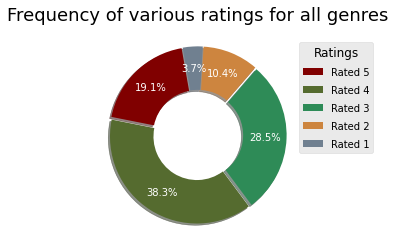

In [ ]:

def get_rating_percentage_total(score):
    rated_count = genre_df.iloc[:, score].values.tolist()
    total_ratings_count = 0
    sum_ratings = 0

    for count in rated_count:
        sum_ratings += count

    for total in total_ratings:
        total_ratings_count += total

    return round((sum_ratings / total_ratings_count) * 100, 1)


ratings_data = [get_rating_percentage_total(5), get_rating_percentage_total(4), get_rating_percentage_total(3),
                get_rating_percentage_total(2), get_rating_percentage_total(1)]


labels = ["Rated 5", "Rated 4", "Rated 3", "Rated 2", "Rated 1"]
fig4, ax4 = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotext = ax4.pie(ratings_data, autopct='%1.1f%%', pctdistance=0.75, shadow=True,
                                  wedgeprops=dict(width=0.5), startangle=100, textprops=dict(color="w"),
                                  explode=(0.02, 0.02, 0.02, 0.02, 0.02), colors=['maroon', 'darkolivegreen',
                                                                                  'seagreen', 'peru', 'slategrey'])

ax4.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.0, 0.05, 0.33, 0.9), title='Ratings',
           title_fontsize='12', labelspacing=0.8)
ax4.set_title("Frequency of various ratings for all genres", size=18)

plt.show()


Figure 3 clearly shows that the average MovieLens user base rates films highly. A score of 4 is very common, while a combination of 1 and 2 only takes up less than 15% of the total rating.

#### Figure 4: Visualization of the average rating distribution for all users.

          rating
userId          
1       4.366379
2       3.948276
3       2.435897
4       3.555556
5       3.636364


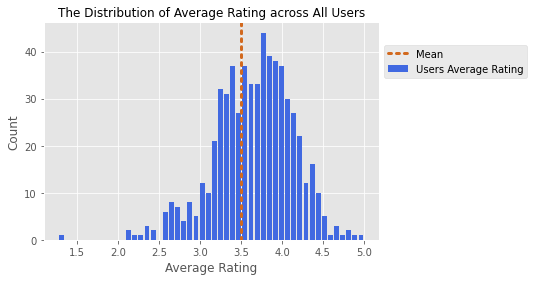

In [ ]:
# Figure 4: Visualization of the distribution of the average rating for all users

users_avg_rating = pd.DataFrame(df_rating.groupby('userId')['rating'].mean())
print(users_avg_rating.head())

# Plotting the histogram above the average rating for all users
users_avg_rating = users_avg_rating['rating']
fig5, ax5 = plt.subplots()
n, bins, patches = ax5.hist(users_avg_rating, label='Users Average Rating',
                            stacked=True, color='royalblue', bins=50, rwidth=0.8)
# Set histogram labels
ax5.set_xlabel('Average Rating', size=12)
ax5.set_ylabel('Count', size=12)
ax5.set_title('The Distribution of Average Rating across All Users', size=12)

# Add a row showing the average rating for all users
plt.axvline(df_rating["rating"].mean(), color='chocolate', linestyle='dotted', dash_capstyle="round",
            linewidth=3, label="Mean")
ax5.legend(bbox_to_anchor=(1, 0.92))

plt.show()

#### Gambar 5: Visualisasi bagaimana rata-rata rating berubah dari waktu ke waktu.

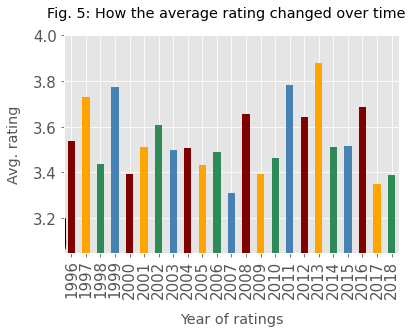

In [ ]:
# Figure 5: Visualization of how the average rating changes over time

# convert timestamp to year
def convert_timestamp_to_year(timestamp):
    date_string = time.ctime(timestamp)
    tokens = date_string.split(sep=" ")
    year = int(tokens[-1])
    return year


ratings_copy = df_rating.copy()
ratings_copy['rating_movie'] = df_rating["timestamp"].map(lambda timestamp: convert_timestamp_to_year(timestamp))
yearly_mean_rating = ratings_copy.groupby('rating_movie')['rating'].mean()

# Plotting bar plots for the average rating over time
plt.figure()
plt.rcParams.update({'font.size': 12})
yearly_mean_rating.plot(kind='bar', figsize=(10, 10), title="Fig. 5: How the average rating changed over time",
                        subplots=True, color=['maroon', 'orange', 'seagreen', 'steelblue'],
                        ylim=(3.05, 4), fontsize=15, label='')
plt.xlabel(xlabel='Year of ratings', labelpad=14)
plt.ylabel(ylabel='Avg. rating', labelpad=12)

# Added arrows along the y-axis to indicate that the axis continues to 0
plt.arrow(x=(-0.4), y=3.2, dx=0, dy=(-0.1), width=0.02, length_includes_head=False, head_length=0.037, head_width=0.06,
          color='black')

plt.show()


## 2. First Iteration: Building a Hybrid Recommender System with CBF and CF models.

### 2.1 Splitting Dataset

In [ ]:

# Separating the rating dataset into feature sets (X) and target labels (y)

X = df_rating.drop(columns='rating')
y = df_rating["rating"].values  # film rating is the target variable to be predicted

# Prepare training datasets (train), validation, and testing (test).
# Split ratio of 75% train data and 25% test and validation data.
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Splitting test data and validation
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

# Create a complete training dataset with X_train and y_train
train_df = X_train.copy()
train_df["rating"] = y_train
train_df

,userId,movieId,timestamp,rating
6137,42,2492,996220790,1.0
1009,7,34048,1121041015,3.0
29207,200,33794,1229885879,4.0
99593,610,924,1493850330,4.5
54044,356,8366,1229140637,5.0
...,...,...,...,...
5695,41,1641,1458939146,2.0
73542,474,1544,974666859,1.0
83281,527,2742,1033173581,1.0
83467,531,593,1032961647,5.0


### 2.2 Baseline Model

To provide context for evaluating more advanced recommendation models, we start by building a very simple basic model. We use a popularity-based approach, in which we calculate the average rating for each film and predict that all users rate all films after the average rating for that film. After that we evaluate it using the RMSE model.

In [ ]:
# Create a new dataframe with average rating for each film.
baseline_y_pred = pd.DataFrame(train_df.groupby('movieId')['rating'].mean())

# The baseline model has not calculated averages for unrated films (if any).
# Therefore, we added movies to the model with a predicted rating equal to the average rating
# for all films in the training data.

# Create data as validation data (y_true) to calculate RMSE from the baseline model
val_movies_dict = {'movieId': X_val["movieId"], 'Actual rating': y_val}
val_df_movie = pd.DataFrame(val_movies_dict)

# Merge training and validation data on movieId
y_pred_and_y_true = pd.merge(baseline_y_pred, val_df_movie, on='movieId')
baseline_y_pred_vs_y_true = y_pred_and_y_true.rename(columns={"rating": "Predicted rating"})

baseline_y_pred_vs_y_true

,movieId,Predicted rating,Actual rating
0,1,3.858553,5.0
1,1,3.858553,4.0
2,1,3.858553,4.0
3,1,3.858553,3.0
4,1,3.858553,4.0
...,...,...,...
12102,187593,4.200000,3.5
12103,187595,3.500000,3.0
12104,187595,3.500000,5.0
12105,187595,3.500000,4.0


In [ ]:
# Calculates RMSE for the baseline model
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_y_pred_vs_y_true["Predicted rating"],
                                                       baseline_y_pred_vs_y_true["Actual rating"])))

RMSE baseline model:  0.9606009727927036


### 2.3 Content Based Filtering

For the Content Based Filtering (CBF) model, we use information about film preferences to predict recommendations. In particular, the CBF model uses information about which items each user has rated, what they are rated for, and what genres of films are rated to build an individual model for each user. The model then predicts ratings for all other films in the dataset that the user has not seen.

We tested several different machine learning algorithms to determine which is best for content recommendations based on the dataset used.

The main advantage of CBF is that it takes individual user preferences into account. For film recommendations, this model is quite suitable, because often we have some favorite film genres, actors, directors, etc. that we enjoy more than others. Unfortunately, the movie dataset from MovieLens contains very few feature films, and content-based filtering models usually require many item features to accurately model user preferences. We try to solve this problem by using feature engineering in section 3.

The weakness of CBF is that this model works with very sparse matrices. We will most likely encounter this problem, as most of the users only rate a few movies. In contrast to Collaborative Filtering, the CBF model also has weaknesses because it does not consider similarities between users, because it only focuses on items (content) and individual users.

Hypothesis:
The CBF model that only uses film genres and user data will not be able to outperform the basic model. To achieve this, CBF requires more features in the film data set. But we'll be doing more testing to see what the results are, and which model will perform better. The best model will be used in the hybrid recommender in chapter 2.5.

#### PREPARING TRAINING DATA

In [ ]:
# ----------- PREPARING TRAINING DATA ----------- #
# Adding movie features (genre, release year) to the training dataset
content_train_df = pd.merge(train_df, df_movie, on='movieId')
content_train_df.drop(columns=['timestamp', 'movieId', 'title'], inplace=True)  # Eliminate unused features

content_train_df

,userId,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,42,1.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,4.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,409,4.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,45,4.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,186,4.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75622,567,1.5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
75623,560,3.0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
75624,125,3.5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
75625,462,5.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create lists with target attributes (film ratings), grouped by userID
y_grouped_by_user = content_train_df.groupby(["userId"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["rating"].values)  # Extract target features (ratings) from sorted data

# Target attribute for the first user
y_train_listed[0]

array([4., 5., 4., 5., 4., 3., 5., 4., 4., 3., 5., 5., 5., 3., 4., 4., 5.,
       4., 5., 5., 5., 4., 5., 5., 4., 5., 3., 4., 4., 4., 5., 5., 4., 5.,
       5., 5., 5., 5., 4., 3., 3., 4., 4., 5., 5., 5., 5., 5., 4., 4., 4.,
       4., 5., 5., 4., 4., 5., 5., 4., 4., 4., 5., 3., 5., 2., 5., 4., 5.,
       5., 4., 5., 4., 5., 2., 4., 5., 4., 5., 5., 3., 5., 5., 5., 4., 5.,
       3., 5., 4., 5., 5., 5., 5., 5., 4., 4., 5., 5., 5., 4., 5., 1., 4.,
       5., 5., 5., 3., 5., 4., 5., 5., 4., 5., 5., 5., 3., 4., 3., 5., 5.,
       5., 5., 4., 5., 5., 4., 3., 5., 4., 4., 5., 2., 5., 5., 5., 5., 5.,
       4., 4., 5., 5., 5., 4., 4., 5., 5., 4., 4., 5., 3., 5., 5., 5., 2.,
       3., 4., 3., 5., 5., 5., 5., 4., 5., 3., 5., 5., 4., 5., 5., 5., 4.,
       4., 4.])

In [ ]:
# Create a list of dataframes with feature sets (film info about genres and year of release), grouped by user ID
content_train_df.drop(columns='rating', inplace=True)
x_grouped_by_user = content_train_df.groupby(["userId"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='userId'))

# Feature set for first time users
x_train_listed[0]

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
552,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
651,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
955,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1435,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68045,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
68885,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
69840,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
70289,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# create a new dataframe for movie data
all_movies = df_movie.drop(columns=['title', 'movieId'])
all_movies

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### PREPARING VALIDATION DATA

In [ ]:
# ----------- PREPARING VALIDATION DATA ----------- #
# Create a 2-dimensional matrix for validation data to make it easier to calculate RMSE.

# Create a list of userIds in the same order as in the grouped dataframe.
user_ids = []
for user_id, group in x_grouped_by_user:
    user_ids.append(user_id)

# List the movieIds in the same order as in the movie dataframe
movie_ids = df_movie["movieId"].values

# Make matrix. Axis 1: userId, axis 2: movieId, Element: original rating from validation data
df_val = X_val.copy()
df_val["rating"] = y_val
validation_matrix = pd.DataFrame(index=user_ids, columns=movie_ids)  # Start with an empty matrix
for array in df_val.to_records():  # Fill in the original rating
    user = array['userId']
    movie = array['movieId']
    true_rating = array['rating']
    validation_matrix.loc[user][movie] = true_rating

validation_matrix

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ----------- CREATING THE DIFFERENT CONTENT-BASED FILTERING MODELS ----------- #
# Define several different machine learning algorithms to be implemented in the model (including hyperparameters) into the dictionary
ml_algorithms = {"Linear regression": LinearRegression(), "Lasso": Lasso(alpha=1.0, max_iter=10000),
                 "KNN_7": KNeighborsRegressor(n_neighbors=7),
                 "RFR": RandomForestRegressor(n_estimators=1000, n_jobs=3, max_features="auto", random_state=0),
                 "SVR": SVR(C=1.0)}

# Stores a list which is later used to build a dataframe containing the performance model
CBF_models_listed = []
RMSE_CBF_listed = []

# for each machine learning algorithm in the dictionary:
for name, ml_alg in ml_algorithms.items():
    # Create an empty list for predictions
    CBF_predictions = []

    # for each user in the training dataset:
    for i, x in enumerate(x_train_listed):
        # Fit model machine learning
        ml_alg.fit(x_train_listed[i], y_train_listed[i])
        # Predict all ratings for each user for all films
        prediction = ml_alg.predict(all_movies)
        prediction = np.clip(prediction, 1, 5)  # Predictions must be a minimum of 1, a maximum of 5
         # Add all predictions to the prediction list
        CBF_predictions.append(prediction)

    #Create a dataframe with predictions
    df_predict = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

    # Create a dataframe with only the predictions for the movie-user combination that appears in the validation set
    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = df_predict.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]

    # Calculate the RMSE for the content-based filtering model and add the results to the list
    RMSE_CBF_listed.append(sqrt(mean_squared_error(num_predict, num_actual)))
    CBF_models_listed.append(name)


# Print results
RMSE_CBF_df = pd.DataFrame({"Model": CBF_models_listed, "RMSE": RMSE_CBF_listed})
print("RMSE of different content-based filtering models without the year of release feature:")
RMSE_CBF_df

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


RMSE of different content-based filtering models without the year of release feature:


,Model,RMSE
0,Linear regression,0.960675
1,Lasso,0.941986
2,KNN_7,0.941553
3,RFR,0.965733
4,SVR,0.937661


The Support Vector Regression (SVR) model performs better than the KNN classifier and outperforms the baseline model. SVR has a much lower RMSE than the others, so we used SVR for the hybrid recommendation in section 2.5. We will also see how feature engineering will influence the best classifiers and linear models. Later we can see whether the RMSE between different models will change or stay the same.

In [ ]:
# # Running the best content-based filtering model so far
# model = Lasso(alpha=1.0, max_iter=10000)
# CBF_predictions = []

# # For each user in the training dataset:
# for i, j in enumerate(x_train_listed):
#     model.fit(x_train_listed[i], y_train_listed[i])
#     prediction = model.predict(all_movies)
#     prediction = np.clip(prediction, 1, 5)
#     CBF_predictions.append(prediction)

# # Creating a dataframe for the predictions
# CBF_model = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

In [ ]:
# Running the best content-based filtering model.
model = SVR(C=1.0)
CBF_predictions = []

# for each user in the training dataset:
for i, j in enumerate(x_train_listed):
    model.fit(x_train_listed[i], y_train_listed[i])
    prediction = model.predict(all_movies)
    prediction = np.clip(prediction, 1, 5)
    CBF_predictions.append(prediction)

# Create a dataframe for predictions
CBF_model = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

### 2.4 Collaborative Filtering

We are now constructing a *Collaborative Filtering (CF)* model using the *K-Nearest Neighbors* algorithm, which we hope will complement and outperform the content-based filtering model. I'm going to use a user based *collaborative filtering* approach. The user-based CF model will calculate predictions based on the most similar user preferences regarding film tastes. Therefore, the CF model only needs to know which users have rated one or more films, along with the value of each rating. The main drawback of the user-based CF model is that there is no contextual information about ratings, or any information about the users or items considered.

Similarity in film preferences is calculated using relative differences in film ratings, with the average of each user's rating subtracted from all users' film ratings. As shown in Figure 4, not all users have the same understanding of the rating scale. Some users tend to rate movies much higher or lower than others, despite having similar film tastes. We measure user similarity as the Pearson correlation coefficient minus 1. After calculating the similarity and distance between all users, the predicted rating for each film is calculated by taking the average of the ratings given by the K nearest neighbors (i.e. the k users who are most similar) who have rate the film in question.

Since the dataset consists of ~600 users and ~9000 movie titles, we expect a high value for the K-hyperparameter to provide better predictions. However, we know that if we increase the number of nearby users, the predicted ratings will converge to the average value of the ratings, and become identical to the baseline model. Increasing K will also result in a large increase in the time it takes to train the model. Seeing that higher K values tend to provide better predictions, we decided to calculate the prediction rating with a weighted average (weight = 1/Pearson's distance) to improve the predictions of models with high K values.

Similar to the CBF section we will train several CF models, although these only vary in hyperparameters, not algorithms. We will then use the best performing CF model for the hybrid recommender in the next section.

In [ ]:
# print training data

train_df.head()

,userId,movieId,timestamp,rating
6137,42,2492,996220790,1.0
1009,7,34048,1121041015,3.0
29207,200,33794,1229885879,4.0
99593,610,924,1493850330,4.5
54044,356,8366,1229140637,5.0


#### DATA PREPROCESSING

In [ ]:
# DATA PREPROCESSING: Calculates the Pearson Distance between all users in the training data
# Creates a 2D matrix (uerId vs movieId) with ratings as elements
user_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')

# We subtract the average rating of each user to enlarge individual preferences
user_matrix = user_matrix.sub(user_matrix.mean(axis=1), axis=0)

# Change NaN with 0, to make the value neutral.
user_matrix = user_matrix.fillna(0.0)

In [ ]:
# Calculates Pearson Correlation for each user,
# Subtract from 1 to get the Pearson Distance between users

user_dist_matrix = 1 - user_matrix.T.corr()
user_dist_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.999627,1.000754,0.972508,0.932555,1.053307,1.019390,0.967238,0.989784,1.010357,...,0.987060,0.994999,0.998799,1.020443,1.021391,1.009159,0.963582,0.940051,0.981260,0.974255
2,0.999627,0.000000,1.000000,1.000000,1.000000,1.000000,1.013698,1.000000,1.000000,0.942327,...,0.992661,1.000000,0.999903,1.000000,1.000000,1.000042,1.000000,1.003638,1.000000,0.991323
3,1.000754,1.000000,0.000000,1.000000,1.000000,1.006855,1.000000,1.000000,1.000000,1.000000,...,0.981802,1.000000,0.992866,1.000000,1.000000,1.032604,1.016257,1.014582,1.000000,0.982973
4,0.972508,1.000000,1.000000,0.000000,1.035939,0.988030,0.944686,1.000571,1.000000,0.934103,...,1.053215,0.967901,1.020930,1.009861,0.968171,0.997945,0.942507,1.020497,1.022849,0.999041
5,0.932555,1.000000,1.000000,1.035939,0.000000,1.060871,0.994522,1.157765,1.000000,1.044139,...,1.018193,0.900710,0.966128,0.978127,1.047548,0.990596,0.962972,1.007861,1.001159,1.003557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,1.009159,1.000042,1.032604,0.997945,0.990596,0.994962,0.989605,0.984414,0.964725,1.034474,...,0.986269,0.981340,0.946333,0.956868,0.974835,0.000000,0.989894,0.957124,0.969381,0.940422
607,0.963582,1.000000,1.016257,0.942507,0.962972,0.966615,0.982812,0.956399,1.016857,0.987195,...,0.967072,0.906985,0.969318,1.001804,1.019530,0.989894,0.000000,0.966144,0.969685,0.972468
608,0.940051,1.003638,1.014582,1.020497,1.007861,0.977994,0.968419,0.953414,0.972898,1.055676,...,0.955588,0.970337,0.986022,0.975450,1.019459,0.957124,0.966144,0.000000,0.944549,0.951599


#### MODELLING

In [ ]:
# MODELING: Predicting the rating for each user with K Nearest Neighbors
# Models with different number of neighbors
ml_algorithms = {'kNN-5': 5, 'kNN-10': 10, 'kNN-20': 20, 'kNN-30': 30, 'kNN-40': 40, "kNN-60": 60}

models_CF = []
RMSE_CF = []

# Train the model and make predictions for users and movies in validation data
for name, num_neighbours in ml_algorithms.items():
    predictions = []

    # For each rating in the validation data
    for index, row in X_val.iterrows():
        # If the movie is in the training data
        if row["movieId"] in X_train["movieId"].unique():
            # Extract all userId for users who have rated movies
            users_rated_movie = X_train.loc[X_train['movieId'] == row['movieId'], 'userId']
            # Sort users by similarity (Pearson Distance)
            users_sorted = (user_dist_matrix.loc[row['userId'], users_rated_movie].sort_values())
            # Set nearest neighbors
            nearest_neighbours = users_sorted[:num_neighbours]
            # Extract rating of nearest neighbors
            nn_data = train_df.loc[train_df['userId'].isin(nearest_neighbours.index.to_list())]
            # Calculate the weight average of the nearest neighbors' ratings
            nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['movieId'] == row['movieId'], 'rating'],
                                                       axis=0, weights=(1/nearest_neighbours))
        else:
            # It is possible that some films in the validation set may not appear in the training set.
             # Because of that we estimate that users will rate these films with the average rating value for all films
            nearest_neighbours_avg_rating = 4

        # Add predictions to the predictions list
        if not np.isnan(nearest_neighbours_avg_rating):
            predictions.append(nearest_neighbours_avg_rating)
        else:
            predictions.append(3)

    models_CF.append(name)
    RMSE_CF.append(sqrt(mean_squared_error(y_val, predictions)))


# See the results display
RMSE_CF_dict = {"Model": models_CF, "RMSE": RMSE_CF}
RMSE_CF_df = pd.DataFrame(RMSE_CF_dict)
RMSE_CF_df

,Model,RMSE
0,kNN-5,0.995267
1,kNN-10,0.974776
2,kNN-20,0.972976
3,kNN-30,0.974322
4,kNN-40,0.975408
5,kNN-60,0.977516


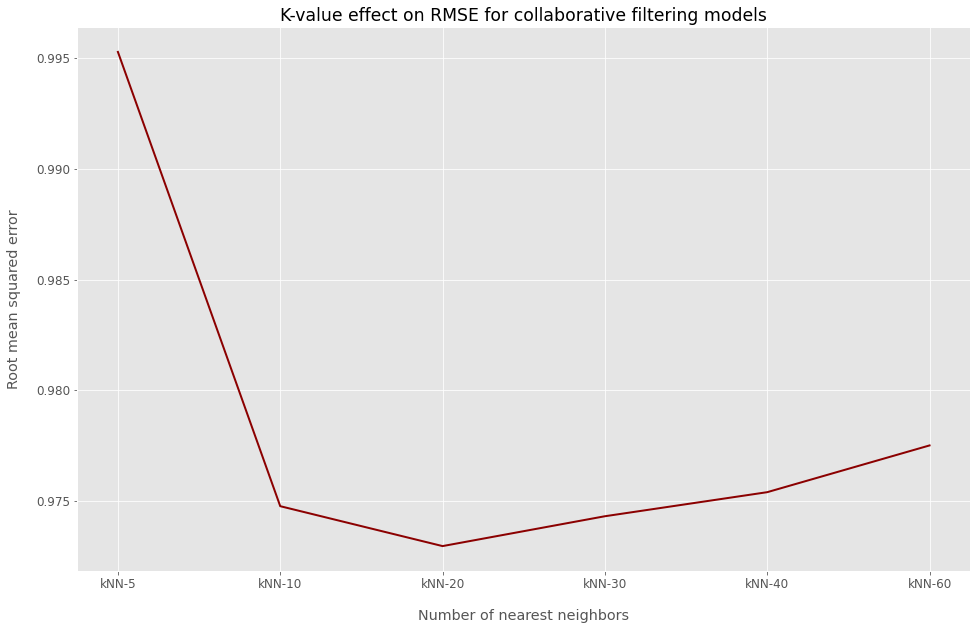

In [ ]:
# Visualize how the number of neighbors affects the root mean squared error
fig7, ax7 = plt.subplots()
ax7.plot(RMSE_CF_df.Model, RMSE_CF_df.RMSE, label="RMSE", color='darkred', linewidth=2)
plt.xlabel("Number of nearest neighbors", labelpad=18)
plt.ylabel("Root mean squared error", labelpad=15)
plt.title("K-value effect on RMSE for collaborative filtering models")
fig7.set_figheight(10)
fig7.set_figwidth(16)
plt.show()

With a K value of 20, the model achieves an RMSE of 0.9729. Higher K-values do not seem to decrease RMSE any further, because RMSE increases at K=30 to K=60. We now select the best model that is K=20 and store the results for use in the hybrid recommender.

In [ ]:
# Running back the best model (kNN-20) and saving the prediction results
best_CF_model = []
RMSE_best_CF = []

# Train the model and make predictions for users and movies in validation data
CF_predictions = []

# For each movie in validation data
for index, row in X_val.iterrows():
    # If there is a movie in the training data
    if row["movieId"] in X_train["movieId"].unique():
        # Extract all userId for users who have rated movies
        users_rated_movie = X_train.loc[X_train['movieId'] == row['movieId'], 'userId']
        # Sort users based on similarity (Pearson distance)
        users_sorted = (user_dist_matrix.loc[row['userId'], users_rated_movie].sort_values())
       # Set neighbor values (k=20)
        nearest_neighbours = users_sorted[:20]
        #Extract nearest neighbors' ratings data
        nn_data = train_df.loc[train_df['userId'].isin(nearest_neighbours.index.to_list())]
        # Calculate the weighted average of the nearest neighbours' ratings
        nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['movieId'] == row['movieId'], 'rating'],
                                                   axis=0, weights=(1/nearest_neighbours))
    else:
        # It is possible that some films in the validation set may not appear in the training set.
         # Because of that we estimate that users will rate these films with the average rating value for all films
        nearest_neighbours_avg_rating = 4

    # Adding predictions to the predictions list
    if not np.isnan(nearest_neighbours_avg_rating):
        CF_predictions.append(nearest_neighbours_avg_rating)
    else:
        CF_predictions.append(4)


### 2.5 Hybrid Recommender

This section aims to combine the best of the CBF and CF models in an effort to create a superior hybrid recommender system. CF and CBF both have strengths and weaknesses, but both can complement each other so that the combination of the two may outperform the CF or CBF models themselves.

In [ ]:
# Extract validation predictions from a CBF dataframe that contains all predictions
CBF_predictions = []
for index, row in X_val.iterrows():
    user_predictions = CBF_model.loc[row["userId"], row["movieId"]]
    CBF_predictions.append(user_predictions)

# Calculates predictions for hybrid "models" with different portions of CF and CBF weighted averages.
print("RMSE combined approach (SVR and KNN-20):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]

for weight in weighted_avgs:
    combined_predictions = np.array([y_pred * weight[0] for y_pred in np.array(CBF_predictions)]) + np.array([y_pred * weight[1] for y_pred in np.array(CF_predictions)])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (SVR and KNN-20):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.8750151103198893 

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.8777478694409947 

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.882137610348958 

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.888159764423058 

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.8957814091349298 

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.9049621323720604 

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.9156550395028139 



## 3. Feature Engineering

The collaborative filtering model we use for the hybrid recommender does not take into account any contextual information (such as timestamps). This means that we cannot improve its performance by adding any new features to the dataset.

However, the content-based filtering model predicts a new rating based on the user's film preferences. More information about user preferences aims to improve hybrid recommender performance. Therefore, we will add one new feature to the movie dataset, and measure the impact of this new feature on the RMSE in CBF and hybrid models.

In [ ]:
# Re-loading datasets
df_rating = pd.read_csv('/content/ratings.csv')
df_movie = pd.read_csv('/content/movies.csv')

In [ ]:
# Creates a new genre feature from genre data

dummies = df_movie['genres'].str.get_dummies(sep='|')
movie_genre = pd.concat([df_movie, dummies], axis=1)

In [ ]:
# Eliminate the column genres and no genres listed because they are not used in testing

df_movie = movie_genre.drop(['genres', '(no genres listed)'], axis=1)
df_movie.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.1 Menambahkan tahun rilis (year) ke dataset movie

In [ ]:
# Added the year feature to the movies dataset

df_movie["year"] = df_movie["title"].str.extract(r"\((\d{4})\)$", expand=False)
df_movie["year"] = pd.to_numeric(df_movie["year"])

In [ ]:
# Cek missing value

print(f'There are {df_movie.isnull().sum().sum()} missing values for "year"')

There are 24 missing values for "year"


In [ ]:
# Change the missing value with the year that appears frequently

df_movie['year'] =df_movie['year'].fillna(df_movie['year'].mode()[0])
df_movie['year'] = df_movie['year'].astype('Int64')

# Print dataset
df_movie.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [ ]:
# Change the movie dataframe in feature engineering to a .csv file
df_movie.to_csv('movies_feature_engineered.csv', index=False)

## 4. Second Iteration: Retraining Content-Based Filtering Model for Enhanced Hybrid Recommender

The addition of one new feature may have enhanced the content-based filtering model. Therefore, we re-trained the three best CBF models and evaluated them on dataset validation, before we implemented the best of the three in the final hybrid recommender.

In [ ]:
# Repeating the train-val-test split with the same random state to get the same split
# Separating the rating dataset into feature sets (X) and target labels (y)
X = df_rating.drop(columns='rating')
y = df_rating["rating"].values  # Film rating as the target variable to be predicted
# Setting up train, validation and test datasets.
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.25, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5, random_state=101)

# Create a complete training dataset with X_train and y_train
train_df = X_train.copy()
train_df["rating"] = y_train

train_df

,userId,movieId,timestamp,rating
6137,42,2492,996220790,1.0
1009,7,34048,1121041015,3.0
29207,200,33794,1229885879,4.0
99593,610,924,1493850330,4.5
54044,356,8366,1229140637,5.0
...,...,...,...,...
5695,41,1641,1458939146,2.0
73542,474,1544,974666859,1.0
83281,527,2742,1033173581,1.0
83467,531,593,1032961647,5.0


### 4.1 Meningkatkan Model Content-based Filtering

In [ ]:
# ----------- PREPARING TRAINING DATA ----------- #
# Adding movie features (genre, year of release) to the training dataset
content_train_df = pd.merge(train_df, df_movie, on='movieId')
content_train_df.drop(columns=['timestamp', 'movieId', 'title'], inplace=True)  # Eliminate unused features

# Create lists with target attributes (film ratings), grouped by userId
y_grouped_by_user = content_train_df.groupby(["userId"])
y_train_listed = []

for i, j in y_grouped_by_user:
    y_train_listed.append(j["rating"].values)  # Extract target features (ratings) from sorted data

# Target attribute for the first user
y_train_listed[0]

# Create a list of dataframes with a collection of feature film info (genre and year of release), grouped by userId
content_train_df.drop(columns='rating', inplace=True)
x_grouped_by_user = content_train_df.groupby(["userId"])
x_train_listed = []

for user_id, group in x_grouped_by_user:
    x_train_listed.append(group.drop(columns='userId'))


# Create a new dataframe for all movie data
all_movies = df_movie.drop(columns=['title', 'movieId'])
all_movies


# ----------- PREPARING VALIDATION DATA ----------- #
# Create a 2-dimensional matrix for validation data to make it easier to calculate RMSE.

# Create a list of userIds in the same order as the grouped dataframes
user_ids = []
for user_id, group in x_grouped_by_user:
    user_ids.append(user_id)
# Create a list of movieIds in the same order as the movie dataset
movie_ids = df_movie["movieId"].values

# Create a matrix. Axis 1: userId, Axis 2: movieId. Element: original rating from validation data
df_val = X_val.copy()
df_val["rating"] = y_val
validation_matrix = pd.DataFrame(index=user_ids, columns=movie_ids)  # Create an empty matrix
for array in df_val.to_records():  # Fill with original rating as matrix element
    user = array['userId']
    movie = array['movieId']
    true_rating = array['rating']
    validation_matrix.loc[user][movie] = true_rating

In [ ]:
# ----------- CREATING THE DIFFERENT IMPROVED CONTENT-BASED FILTERING MODELS ----------- #
ml_algorithms = {"Lasso": Lasso(alpha=1.0, max_iter=10000), "KNN_7": KNeighborsRegressor(n_neighbors=7),
                 "SVR": SVR(C=1.0)}

# Save the list which will be used to create a dataframe containing the performance model
improved_models_listed = []
improved_models_RMSE = []

# For each machine learning algorithm in the dictionary:
for name, ml_alg in ml_algorithms.items():
    # Create an empty list for predictions
    CBF_predictions = []

    # For each user in the training dataset:
    for i, x in enumerate(x_train_listed):
        # Fit machine learning models with release year features
        ml_alg.fit(x_train_listed[i], y_train_listed[i])
        # Predictions of all ratings for users on all films
        prediction = ml_alg.predict(all_movies)
        prediction = np.clip(prediction, 1, 5)# Minimum prediction 1, maximum 5
         # Add all predictions to predictions list
        CBF_predictions.append(prediction)

    # Create a dataframe containing predictions
    CBF_y_pred_df = pd.DataFrame(CBF_predictions, index=user_ids, columns=movie_ids)

   # Create a dataframe containing only predictions for the movie-user combination that appears in the validation data
    num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
    num_predict = CBF_y_pred_df.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]

    # Calculate the RMSE for the content-based filtering model and add the results to the list
    improved_models_RMSE.append(sqrt(mean_squared_error(num_predict, num_actual)))
    improved_models_listed.append(name)


# Print results
RMSE_content_df_improved = pd.DataFrame({"Model": improved_models_listed, "RMSE": improved_models_RMSE})
print("RMSE of different content-based filtering models, including the year of release feature")
RMSE_content_df_improved

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


RMSE of different content-based filtering models, including the year of release feature


,Model,RMSE
0,Lasso,0.931716
1,KNN_7,0.934366
2,SVR,0.964400


Previously, SVR appeared with an RMSE of 0.937661, outperforming KNN and Lasso. After training with the new features, the RMSE value changed to 0.964400, which means that SVR experienced an error increase of 0.020899. The increase in the RMSE value shows that the SVR model experiences a decrease in performance when the CBF model is added a new feature.

In contrast, the Lasso and KNN models both experienced a decrease in the RMSE value. After the addition of new features, the model with the best evaluation value is the Lasso model. The performance improvement is not that high, but still significant enough to confirm that the engineering feature has succeeded in improving the prediction model performance.

In [ ]:
# Running the best improved content-based filtering model
model = Lasso(alpha=1.0, max_iter=10000)
CBF_improved_predictions = []
# For each user in the training dataset:
for i, j in enumerate(x_train_listed):
    model.fit(x_train_listed[i], y_train_listed[i])
    prediction = model.predict(all_movies)
    prediction = np.clip(prediction, 1, 5)
    CBF_improved_predictions.append(prediction)

# Create a dataframe for predictions
CBF_improved_model = pd.DataFrame(CBF_improved_predictions, index=user_ids, columns=movie_ids)

# Create a dataframe containing only predictions for the movie-user combination that appears in the validation data
num_actual = validation_matrix.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
num_predict = CBF_improved_model.to_numpy().flatten()[validation_matrix.notna().to_numpy().flatten()]
print("RMSE of best content-based filtering model:", sqrt(mean_squared_error(num_predict, num_actual)))

# Save predictions of the best CBF models to disk for later use
CBF_improved_model.to_pickle("./CBF_model.pkl")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


RMSE of best content-based filtering model: 0.931716103242597


### 4.2 Upgraded Hybrid Recommender Model

We will now implement the improved CBF model in the new hybrid recommender, and test different weight combinations against the validation set.

In [ ]:
# Extract validation predictions from an enhanced content dataframe that contains all predictions
CBF_predictions = []
for index, row in X_val.iterrows():
    user_predictions = CBF_model.loc[row["userId"], row["movieId"]]
    CBF_predictions.append(user_predictions)

# Calculates predictions for hybrid "models" with different portions of CF and CBF weighted averages.
print("RMSE combined approach (Lasso and KNN-20):")
weighted_avgs = [(0.5, 0.5), (0.45, 0.55), (0.4, 0.6), (0.35, 0.65), (0.3, 0.7), (0.25, 0.75), (0.20, 0.80)]

for weight in weighted_avgs:
    combined_predictions = np.array([y_pred * weight[0] for y_pred in np.array(CBF_predictions)]) + np.array([y_pred * weight[1] for y_pred in np.array(CF_predictions)])
    print(f"RMSE for combined approach with CBF weighted {weight[0]} and CF weighted {weight[1]}: \n",
          sqrt(mean_squared_error(y_val, combined_predictions)), "\n")

RMSE combined approach (Lasso and KNN-20):
RMSE for combined approach with CBF weighted 0.5 and CF weighted 0.5: 
 0.8750151103198893 

RMSE for combined approach with CBF weighted 0.45 and CF weighted 0.55: 
 0.8777478694409947 

RMSE for combined approach with CBF weighted 0.4 and CF weighted 0.6: 
 0.882137610348958 

RMSE for combined approach with CBF weighted 0.35 and CF weighted 0.65: 
 0.888159764423058 

RMSE for combined approach with CBF weighted 0.3 and CF weighted 0.7: 
 0.8957814091349298 

RMSE for combined approach with CBF weighted 0.25 and CF weighted 0.75: 
 0.9049621323720604 

RMSE for combined approach with CBF weighted 0.2 and CF weighted 0.8: 
 0.9156550395028139 



## 5. N-Fold Cross Validation Best Model

In [ ]:
# Set n-fold = 4
kfold_validation=KFold(n_splits=4, shuffle=True)

In [ ]:
# Define MSE dan set greater_is_better=True
mse = make_scorer(mean_squared_error, greater_is_better = True)

### 5.1 CV SVR On Iteration 1 CBF Models

In [ ]:
svr = SVR(C=1.0)

# Perform cross validation with n-fold = 4
result_svr=cross_val_score(svr,X,y,cv=kfold_validation, scoring=mse)
print('4-Fold Iteration Value:{}'.format(result_svr))
print('SVR MSE mean value:{}'.format(np.mean(result_svr)))

4-Fold Iteration Value:[1.11135397 1.12088537 1.11386172 1.10629562]
SVR MSE mean value:1.113099168198266


### 5.2 CV KNN-20 On Iteration 1 CF Model

In [ ]:
knn = KNeighborsRegressor(n_neighbors=20)

# Perform cross validation with n-fold = 4
result_knn=cross_val_score(knn,X,y,cv=kfold_validation, scoring=mse)
print('4-Fold Iteration Value:{}'.format(result_knn))
print('KNN MSE mean value:{}'.format(np.mean(result_knn)))

4-Fold Iteration Value:[0.85201238 0.86038176 0.85707461 0.83471082]
KNN MSE mean value:0.8510448897219248


### 5.3 CV Lasso On Model CBF Improved

In [ ]:
lsso = Lasso(alpha=1.0, max_iter=10000)

# Perform cross validation with n-fold = 4
result_lsso=cross_val_score(lsso,X,y,cv=kfold_validation, scoring=mse)
print('4-Fold Iteration Value:{}'.format(result_lsso))
print('Lasso MSE mean value:{}'.format(np.mean(result_lsso)))

4-Fold Iteration Value:[1.08463353 1.08011367 1.07282934 1.09983567]
Lasso MSE mean value:1.0843530530259489


## 6. Final Test and Evaluation

Finally, we test the performance of the improved hybrid recommender by making predictions on the test dataset. We give weight to the CBF model 0.5 and CF model 0.5, because this combination has proven to be the most optimal from the tests conducted on the previous validation set.

In [ ]:
# Building a hybrid recommender: Collaborative Filtering (CF)
CF_predictions_test = []
for index, row in X_test.iterrows():
    if row["movieId"] in X_train["movieId"].unique():
        users_rated_movie = X_train.loc[X_train['movieId'] == row['movieId'], 'userId']
        users_sorted = (user_dist_matrix.loc[row['userId'], users_rated_movie].sort_values())
        n_neighbours = users_sorted[:20]
        nn_data = train_df.loc[train_df['userId'].isin(n_neighbours.index.to_list())]
        nearest_neighbours_avg_rating = np.average(nn_data.loc[train_df['movieId'] == row['movieId'], 'rating'],
                                                   axis=0, weights=(1/n_neighbours))
    else:
        nearest_neighbours_avg_rating = train_df["rating"].mean()

    # Add predictions to the list
    if not np.isnan(nearest_neighbours_avg_rating):
        CF_predictions_test.append(nearest_neighbours_avg_rating)
    else:
        CF_predictions_test.append(4)

print("RMSE KNN_20:", sqrt(mean_squared_error(y_test, CF_predictions_test)))

RMSE KNN_20: 0.9686234681766867


In [ ]:
# Building a hybrid recommender: Content-Based filtering (CBF)
# Extract predictions for movies and users in data testing
# of the CBF dataframe (which contains predictions for all movies and all users)
CBF_predictions_test = []
for index, row in X_test.iterrows():
    user_predictions = CBF_improved_model.loc[row["userId"], row["movieId"]]
    CBF_predictions_test.append(user_predictions)

print("RMSE Lasso:", sqrt(mean_squared_error(y_test, CBF_predictions_test)))

RMSE Lasso: 0.9335171212683905


In [ ]:
# Calculating hybrid recommendations
hybrid_predictions_test = (np.array([y_pred * 0.35 for y_pred in np.array(CBF_predictions_test)])
                           + np.array([y_pred * 0.65 for y_pred in np.array(CF_predictions_test)]))

# Displays the test results from the Hybrid Recommendation training model on data testing
print(f"RMSE hybrid recommendations (test data): {sqrt(mean_squared_error(y_test, hybrid_predictions_test))} ")

RMSE hybrid recommendations (test data): 0.8986530774324567 


## 7. Kesimpulan

The hybrid recommender model that is applied can make predictions with an RMSE value of 0.8986 on data testing. Meanwhile, we know that the baseline model produces an RMSE value of 0.9606. So there is a sizeable increase in recommendations after applying measures to specific user preferences grouping users with similar tastes. One of the measures implemented is the addition of a new feature, namely the release year of each film, which increases the performance of hybrid recommendations.

## Referensi

**Main Reference :**
[Creating a Hybrid Recommender System
using Content-based and Collaborative Filtering](https://github.com/SebastianRokholt/Hybrid-Recommender-System/blob/main/analysis-and-modelling.ipynb)